In [1]:
from pscore_data_reader_preproc import read_and_process_data, model_evaluation
import pandas as pd
from tensorflow import keras
from tensorflow.keras import Input, layers, models, metrics, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt     # data viz

In [2]:
# Read in the data using the pre-processing code
x_train, y_train, x_test, y_test, team_values = read_and_process_data(
     r"E:\github_repos\Private_Projects\NCAA_FBS_AP_Ranking_Predictions\python_ap\scripts_and_data\data\score_pred_train_data.csv",
     r"E:\github_repos\Private_Projects\NCAA_FBS_AP_Ranking_Predictions\python_ap\scripts_and_data\data\score_pred_test_data.csv",
     True
)

# check to make sure the data looks right
x_train.shape
x_test.shape

train data has shape: (14648, 490)
test data has shape: (132, 490)


(132, 490)

In [3]:
# set up plot and early stopping 
#Need function to plot loss
def plot_training_history(history, epochs=200):
    """
    Plots the loss, MAE, and MSE for both training and validation splits.

    Args:
        history: The training history returned by model.fit().
        epochs: The number of epochs (default is 200).
    """
    # Get the number of epochs from the history object
    epochs = len(history.history['loss'])  # Number of completed epochs

    # Extract training and validation metrics
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_mae = history.history['mae']
    val_mae = history.history['val_mae']
    train_mse = history.history['mse']
    val_mse = history.history['val_mse']

    # Create subplots for the loss, MAE, and MSE
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    # Plot training loss vs. validation loss
    axs[0].plot(range(1, epochs + 1), train_loss, label='Train Loss')
    axs[0].plot(range(1, epochs + 1), val_loss, label='Val Loss', linestyle='--')
    axs[0].set_title('Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    # Plot training MAE vs. validation MAE
    axs[1].plot(range(1, epochs + 1), train_mae, label='Train MAE')
    axs[1].plot(range(1, epochs + 1), val_mae, label='Val MAE', linestyle='--')
    axs[1].set_title('Mean Absolute Error (MAE)')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('MAE')
    axs[1].legend()

    # Plot training MSE vs. validation MSE
    axs[2].plot(range(1, epochs + 1), train_mse, label='Train MSE')
    axs[2].plot(range(1, epochs + 1), val_mse, label='Val MSE', linestyle='--')
    axs[2].set_title('Mean Squared Error (MSE)')
    axs[2].set_xlabel('Epochs')
    axs[2].set_ylabel('MSE')
    axs[2].legend()

    # Display the plots
    plt.tight_layout()
    plt.show()

# also set up early stopping as needed
early_stopping = EarlyStopping(monitor='val_loss',  # You can change this to 'val_mae' or 'val_mse'
                               patience=10,  # Number of epochs with no improvement after which training will stop
                               restore_best_weights=True,  # Restore model weights from the epoch with the best validation loss
                               verbose=1)  # Show a message when early stopping is triggered


In [25]:
# this block will set up the inital model
# build inital simple model
tf_model = keras.Sequential([
    Input(shape=(x_train.shape[1],)),   # Explicit Input layer to define input shape. Seems to not be widely used online, but documentation suggests this is prefered method via keras
    layers.Dense(64, activation='relu'),        # hidden layer
    layers.Dense(1, activation='linear')        # Output layer for regression
])

# compile the model
tf_model.compile(optimizer='adam', loss='mse', metrics=['mae','mse'])

# summary of the model, to check
tf_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                      │ (None, 64)                  │          21,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,633 (84.50 KB)

 Trainable params: 21,633 (84.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# lets fit the first model
model_1 = tf_model.fit(x_train, y_train, epochs=200, batch_size=32, validation_split = 0.2) # note batch size is 32 by default, larger faster but more memory


Epoch 1/200
367/367 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 577.7255 - mae: 19.8072 - mse: 577.7255 - val_loss: 279.8294 - val_mae: 13.3499 - val_mse: 279.8294
Epoch 2/200
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step - loss: 205.4049 - mae: 11.3983 - mse: 205.4049 - val_loss: 254.5935 - val_mae: 12.9754 - val_mse: 254.5935
Epoch 3/200
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step - loss: 170.9318 - mae: 10.4056 - mse: 170.9318 - val_loss: 211.5502 - val_mae: 11.7666 - val_mse: 211.5502
Epoch 4/200
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step - loss: 162.0352 - mae: 10.1503 - mse: 162.0352 - val_loss: 209.4736 - val_mae: 11.7215 - val_mse: 209.4736
Epoch 5/200
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step - loss: 155.9248 - mae: 10.0423 - mse: 155.9248 - val_loss: 184.3877 - val_mae: 10.8713 - val_mse: 184.3877
Epoch 6/200
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step - loss: 148.6674 - mae: 9.7638 - mse: 148.6674 - val_loss: 167.1641 - val_mae: 10.4018 - val_mse: 167.1641
Epoch 7/200
367/367 ━━━━━

In [ ]:
# not lets plot
plot_training_history(model_1)

# Looks like some very bad overfitting! so lets initaite the early stopping 

In [ ]:
# this block will set up the inital model
# build inital simple model
tf_model_2 = keras.Sequential([
    Input(shape=(x_train.shape[1],)),   # Explicit Input layer to define input shape. Seems to not be widely used online, but documentation suggests this is prefered method via keras
    layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.0001)),        # hidden layer
    layers.Dense(1, activation='linear')        # Output layer for regression
])

# compile the model
tf_model_2.compile(optimizer='adam', loss='mse', metrics=['mae','mse'])

# summary of the model, to check
tf_model_2.summary()

In [ ]:
# lets fit the second model
model_2 = tf_model_2.fit(x_train, y_train, epochs=200, batch_size=32, validation_split = 0.2) # note batch size is 32 by default, larger faster but more memory


In [ ]:
# not lets plot
plot_training_history(model_2)

# still lots of apparent overfitting
# could try increasing the l2 rate, also could try to reduce the learning rate

In [16]:
# build more models! 
# increasing l2 rate from .0001 to .001, stronger effect
# also increasing rate from .001 to .01
# and drop layers from 64 to 32
tf_model_3 = keras.Sequential([
    Input(shape=(x_train.shape[1],)),   # Explicit Input layer to define input shape. Seems to not be widely used online, but documentation suggests this is prefered method via keras
    layers.Dense(16, activation='relu',kernel_regularizer=regularizers.l2(0.01)),
    layers.Dense(16, activation='relu',kernel_regularizer=regularizers.l2(0.01)),   
    layers.Dense(1, activation='linear')        # Output layer for regression
])

# compile the model
optimizer = Adam(learning_rate=0.001) 
tf_model_3.compile(optimizer=optimizer, loss='mse', metrics=['mae','mse'])

# summary of the model, to check
tf_model_3.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                      │ (None, 16)                  │           7,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,145 (31.82 KB)

 Trainable params: 8,145 (31.82 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# lets fit the third model
model_3 = tf_model_3.fit(x_train, y_train, epochs=25, batch_size=32, validation_split = 0.2) # note batch size is 32 by default, larger faster but more memory


Epoch 1/25
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step - loss: 125.9997 - mae: 8.9395 - mse: 123.3146 - val_loss: 167.5824 - val_mae: 10.2665 - val_mse: 164.8532
Epoch 2/25
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 125.5950 - mae: 8.9015 - mse: 122.8533 - val_loss: 159.0794 - val_mae: 9.9430 - val_mse: 156.2970
Epoch 3/25
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step - loss: 122.2489 - mae: 8.7719 - mse: 119.4477 - val_loss: 167.4033 - val_mae: 10.2964 - val_mse: 164.5538
Epoch 4/25
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step - loss: 122.1041 - mae: 8.7787 - mse: 119.2415 - val_loss: 159.3606 - val_mae: 9.9515 - val_mse: 156.4518
Epoch 5/25
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step - loss: 123.5310 - mae: 8.8293 - mse: 120.6040 - val_loss: 175.1431 - val_mae: 10.5354 - val_mse: 172.1785
Epoch 6/25
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step - loss: 125.6626 - mae: 8.9095 - mse: 122.6845 - val_loss: 163.2756 - val_mae: 10.1029 - val_mse: 160.2587
Epoch 7/25
367/367 ━━━━━━━━━━━━━━━━━━━

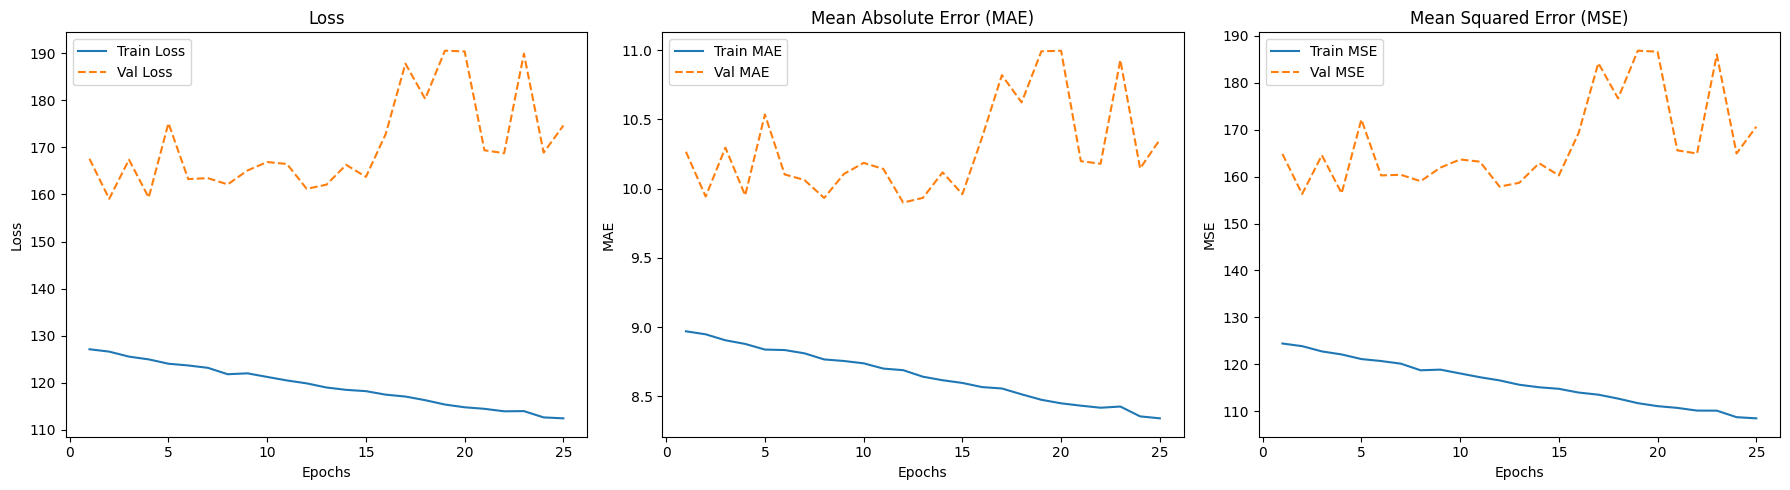

In [19]:
# not lets plot
plot_training_history(model_3)

# This does seem to be better, but still some concerns. Am thinking I need to cut down the number of variables. Maybe lets look at what a vif from something like xgboost suggests
# also maybe lets just look at what the model values are

In [14]:
# lets see what the current model is suggesting
tf_model_3.fit(x_train, y_train, epochs=25, batch_size=32, validation_split = 0.2)


Epoch 1/25
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 126.8383 - mae: 8.9613 - mse: 124.1860 - val_loss: 160.1132 - val_mae: 9.9078 - val_mse: 157.4216
Epoch 2/25
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step - loss: 123.4421 - mae: 8.8203 - mse: 120.7315 - val_loss: 163.6512 - val_mae: 10.1541 - val_mse: 160.8868
Epoch 3/25
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step - loss: 123.3800 - mae: 8.8289 - mse: 120.6017 - val_loss: 165.8324 - val_mae: 10.2222 - val_mse: 163.0110
Epoch 4/25
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step - loss: 124.4729 - mae: 8.8861 - mse: 121.6328 - val_loss: 165.0598 - val_mae: 10.1726 - val_mse: 162.1879
Epoch 5/25
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step - loss: 122.7806 - mae: 8.7778 - mse: 119.8935 - val_loss: 162.3064 - val_mae: 10.0680 - val_mse: 159.3751
Epoch 6/25
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step - loss: 121.8496 - mae: 8.7848 - mse: 118.9022 - val_loss: 166.2611 - val_mae: 10.2521 - val_mse: 163.2761
Epoch 7/25
367/367 ━━━━━━━━━━━━━━━━━━

In [15]:
y_pred_train = tf_model_3.predict(x_train)
model_evaluation(y_train, y_pred_train)

458/458 ━━━━━━━━━━━━━━━━━━━━ 0s 508us/step
R-squared: 0.388
Mean Squared Error (MSE): 119.688
Mean Absolute Error (MAE): 8.650


In [34]:
x_train['predictions'] = y_pred_train
x_train['actual'] = y_train
x_train.to_csv("data.csv")

In [35]:
y_pred_test = tf_model_3.predict(x_test)
x_test['predictions'] = y_pred_test
x_test['actual'] = y_test
x_test = pd.concat([x_test, team_values], axis=1)
x_test.to_csv("data_test.csv")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [5]:
# build more models! 
# lets do l1 reg

tf_model_4 = keras.Sequential([
    Input(shape=(x_train.shape[1],)),   # Explicit Input layer to define input shape. Seems to not be widely used online, but documentation suggests this is prefered method via keras
    layers.Dense(16, activation='relu',kernel_regularizer=regularizers.l1(0.01)),
    layers.Dense(16, activation='relu',kernel_regularizer=regularizers.l1(0.01)),   
    layers.Dense(1, activation='linear')        # Output layer for regression
])

# compile the model
optimizer = Adam(learning_rate=0.001) 
tf_model_4.compile(optimizer=optimizer, loss='mse', metrics=['mae','mse'])

# summary of the model, to check
tf_model_4.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 16)                  │           7,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,145 (31.82 KB)

 Trainable params: 8,145 (31.82 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# lets fit the third model
model_4 = tf_model_4.fit(x_train, y_train, epochs=25, batch_size=32, validation_split = 0.2) # note batch size is 32 by default, larger faster but more memory


Epoch 1/25
367/367 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 552.5894 - mae: 19.2092 - mse: 547.6050 - val_loss: 260.5287 - val_mae: 12.9795 - val_mse: 255.0964
Epoch 2/25
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - loss: 187.9642 - mae: 10.8027 - mse: 182.5176 - val_loss: 246.9903 - val_mae: 12.6644 - val_mse: 241.4858
Epoch 3/25
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step - loss: 176.8240 - mae: 10.4753 - mse: 171.2859 - val_loss: 204.0323 - val_mae: 11.4093 - val_mse: 198.4267
Epoch 4/25
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step - loss: 161.2063 - mae: 10.0075 - mse: 155.5694 - val_loss: 172.0775 - val_mae: 10.3460 - val_mse: 166.3907
Epoch 5/25
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step - loss: 155.8690 - mae: 9.7913 - mse: 150.1571 - val_loss: 181.8793 - val_mae: 10.7067 - val_mse: 176.1201
Epoch 6/25
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step - loss: 152.7663 - mae: 9.7215 - mse: 146.9750 - val_loss: 166.4526 - val_mae: 10.2190 - val_mse: 160.6163
Epoch 7/25
367/367 ━━━━━━━━━━━━━

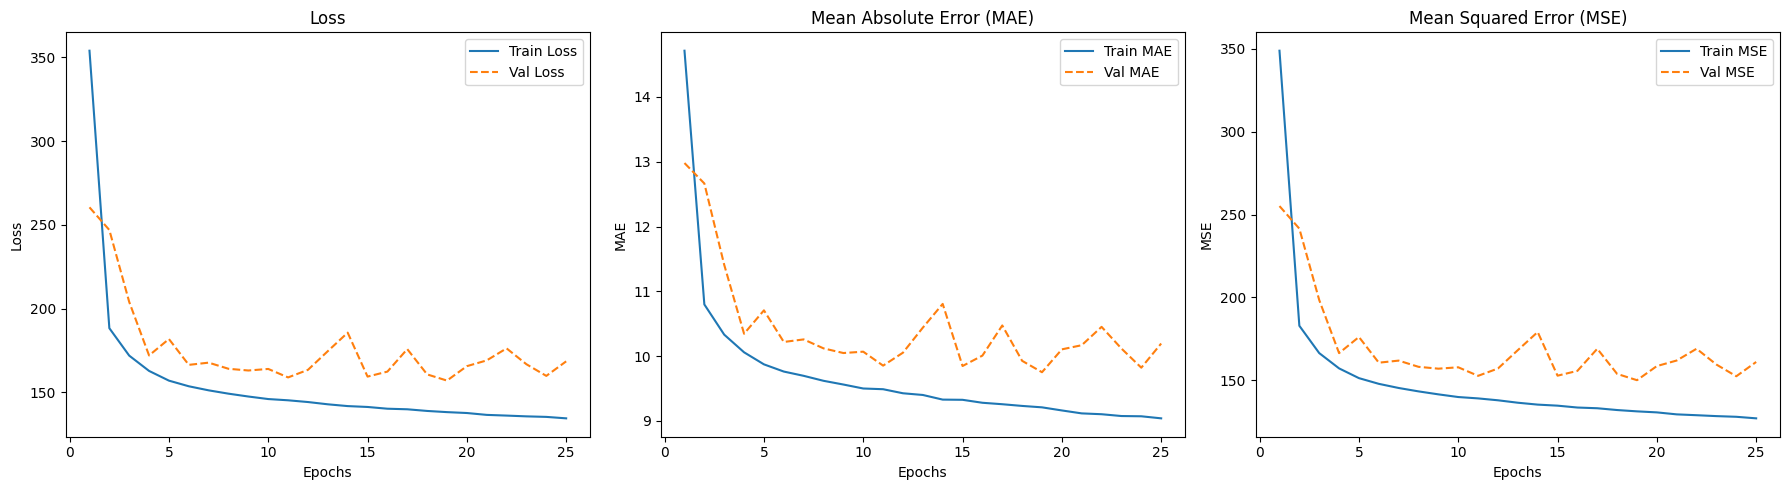

In [8]:
# not lets plot
plot_training_history(model_4)

# This does seem to be better, but still some concerns. Am thinking I need to cut down the number of variables. Maybe lets look at what a vif from something like xgboost suggests
# also maybe lets just look at what the model values are

In [9]:
# lets see what the current model is suggesting
tf_model_4.fit(x_train, y_train, epochs=25, batch_size=32, validation_split = 0.2)

Epoch 1/25
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step - loss: 132.1312 - mae: 8.9504 - mse: 124.5884 - val_loss: 159.2704 - val_mae: 9.8051 - val_mse: 151.6792
Epoch 2/25
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step - loss: 132.9629 - mae: 8.9922 - mse: 125.3430 - val_loss: 162.4626 - val_mae: 9.9283 - val_mse: 154.7866
Epoch 3/25
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step - loss: 131.5121 - mae: 8.9438 - mse: 123.8156 - val_loss: 161.0909 - val_mae: 9.7802 - val_mse: 153.3426
Epoch 4/25
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step - loss: 131.2748 - mae: 8.8760 - mse: 123.4903 - val_loss: 165.2827 - val_mae: 9.9931 - val_mse: 157.4567
Epoch 5/25
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step - loss: 131.4903 - mae: 8.9317 - mse: 123.6274 - val_loss: 169.9586 - val_mae: 10.1973 - val_mse: 162.0644
Epoch 6/25
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step - loss: 132.4828 - mae: 8.9360 - mse: 124.5428 - val_loss: 171.3425 - val_mae: 10.2317 - val_mse: 163.3683
Epoch 7/25
367/367 ━━━━━━━━━━━━━━━━━━━

In [10]:
y_pred_train = tf_model_4.predict(x_train)
model_evaluation(y_train, y_pred_train)

458/458 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step
R-squared: 0.380
Mean Squared Error (MSE): 121.236
Mean Absolute Error (MAE): 8.767
